In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from joblib import dump, load
from imblearn.over_sampling import SMOTE

warnings.filterwarnings(action='ignore')
random_seed = 42
np.random.seed(random_seed)

## Data Load

- train set -> train, val
    - model훈련 -> train 
    - model평가 -> val 

최종 model 선택 후 
- val set -> test set.
    - model최종평가 -> test

In [2]:
# train data
label_path = "./data/train/label/"
data_path = "./data/processed/"

train_label = pd.read_csv(label_path+"1.걸음걸이/training_label.csv")
train_activity = pd.read_csv(data_path+'train_activity_add.csv')
train_sleep = pd.read_csv(data_path+'train_sleep_add.csv')

# test data
test_label = pd.read_csv("./data/validation/label/1.걸음걸이/val_label.csv")
test_activity = pd.read_csv(data_path+"/test_activity_add.csv")
test_sleep = pd.read_csv(data_path+"/test_sleep_add.csv")

In [3]:
print("Train Activity: ", train_activity.shape)
print("Train Sleep: ", train_sleep.shape)
print("="*30)
print("Test Activity: ", test_activity.shape)
print("Test Sleep: ", test_sleep.shape)

Train Activity:  (9704, 60)
Train Sleep:  (9705, 44)
Test Activity:  (2478, 60)
Test Sleep:  (2478, 44)


In [4]:
def merge_data(df1, df2, label):
    '''
    기능: 1. activity,sleep concat
         2. label merge
    '''
    drop_cols = ['activity_type', 'activity_date', 'DIAG_NM']
    df = pd.concat([df1.drop(['DIAG_NM'],axis=1), df2.drop(drop_cols+['EMAIL'],axis=1)], axis=1)
    label.rename(columns={"SAMPLE_EMAIL": "EMAIL"}, inplace=True)
    df = df.merge(label, how='inner', on="EMAIL")
    return df


# 모델 훈련 함수
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# 평가 함수
def evaluate_model(model, X, y, encoder, dataset_name="Dataset"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    print(f"=== {dataset_name} Evaluation ===")
    print(f"Accuracy: {acc:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(classification_report(y, y_pred, target_names=['CN', 'MCI', 'Dem']))
    # print("="*60)

# 모델 저장 함수
def save_model(model, model_name, folder="saved_models"):
    os.makedirs(folder, exist_ok=True)
    model_path = os.path.join(folder, f"{model_name.replace(' ', '_')}.joblib")
    dump(model, model_path)
    print(f"Model saved to {model_path}")

# 모델 불러오기 함수
def load_model(model_path):
    return load(model_path)

In [5]:
train = merge_data(train_activity, train_activity, train_label)

In [6]:
y = train.iloc[:,-1]
y_order = ['CN', 'MCI', 'Dem']
activity_type_order = ['morning', 'intermediate','evening']

activity_type_encoder = OrdinalEncoder(categories=[activity_type_order])
train['activity_type'] = activity_type_encoder.fit_transform(train[['activity_type']])

y_encoder = OrdinalEncoder(categories=[y_order])
train['DIAG_NM'] = y_encoder.fit_transform(train[['DIAG_NM']])

In [7]:
# 그룹 단위로 Train/Test 분할
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=random_seed)
train_idx, val_idx = next(splitter.split(train, groups=train["EMAIL"]))

train_data = train.iloc[train_idx]
val_data = train.iloc[val_idx]

print("Train 데이터 사람 ID:", train_data["EMAIL"].nunique())
print("Test 데이터 사람 ID:", val_data["EMAIL"].nunique())


Train 데이터 사람 ID: 112
Test 데이터 사람 ID: 29


In [8]:
print("========== train_data ========== \n", train_data.groupby('DIAG_NM')['EMAIL'].nunique())
print("========== val_data ========== \n", val_data.groupby('DIAG_NM')['EMAIL'].nunique())

========== train_data ========== 
 DIAG_NM
0.0    66
1.0    39
2.0     7
Name: EMAIL, dtype: int64
========== val_data ========== 
 DIAG_NM
0.0    19
1.0     8
2.0     2
Name: EMAIL, dtype: int64


In [9]:
X_train = train_data.select_dtypes(include=[np.number]).drop(columns=['DIAG_NM'])
X_val = val_data.select_dtypes(include=[np.number]).drop(columns=['DIAG_NM'])
y_train = train_data['DIAG_NM']
y_val = val_data['DIAG_NM']

print('X_train: {}, y_train: {}'.format(X_train.shape, y_train.shape))
print('X_val  : {}, y_val  : {}'.format(X_val.shape, y_val.shape))

X_train: (7866, 113), y_train: (7866,)
X_val  : (1838, 113), y_val  : (1838,)


In [10]:
y_encoder.categories_ 

[array(['CN', 'MCI', 'Dem'], dtype=object)]

In [11]:
# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

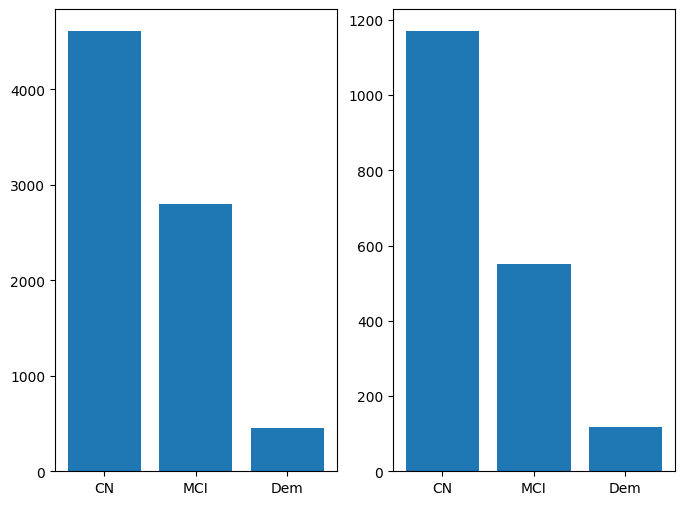

In [12]:
fig, axes = plt.subplots(1,2, figsize=(8,6))
train_df=pd.Series(y_train).value_counts().reset_index()
val_df=pd.Series(y_val).value_counts().reset_index()

axes[0].bar(data=train_df, x='DIAG_NM', height='count')
axes[1].bar(data=val_df, x='DIAG_NM', height='count')
axes[0].set_xticks(np.arange(0,3), ['CN', 'MCI', 'Dem'])
axes[1].set_xticks(np.arange(0,3), ['CN', 'MCI', 'Dem'])
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.show()

## Train and Evaluate Models

In [13]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [14]:
# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed, max_depth=5),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed, learning_rate=0.001)
}

In [15]:
y_resampled.value_counts()

DIAG_NM
1.0    4610
0.0    4610
2.0    4610
Name: count, dtype: int64

In [16]:
encoder = y_encoder
model = models["Gradient Boosting"]
model.fit(X_resampled, y_resampled)

evaluate_model(model, X_resampled, y_resampled, encoder, dataset_name="Gradient Boosting Train")
evaluate_model(model, X_val, y_val, encoder, dataset_name="Gradient Boosting Validation")


=== Gradient Boosting Train Evaluation ===
Accuracy: 0.64
F1-score: 0.64
              precision    recall  f1-score   support

          CN       0.59      0.51      0.55      4610
         MCI       0.58      0.59      0.59      4610
         Dem       0.73      0.83      0.77      4610

    accuracy                           0.64     13830
   macro avg       0.64      0.64      0.64     13830
weighted avg       0.64      0.64      0.64     13830

=== Gradient Boosting Validation Evaluation ===
Accuracy: 0.41
F1-score: 0.43
              precision    recall  f1-score   support

          CN       0.63      0.39      0.48      1170
         MCI       0.31      0.42      0.36       550
         Dem       0.17      0.54      0.26       118

    accuracy                           0.41      1838
   macro avg       0.37      0.45      0.37      1838
weighted avg       0.50      0.41      0.43      1838



In [17]:
# Feature Importance 확인
importances = model.feature_importances_
final_df = pd.DataFrame({"Features": X_train.columns, "Importances":importances})
final_df['Importances'] = final_df['Importances'].apply("{:.2f}".format)
final_df.sort_values(by="Importances", ascending=False).head(10)

,Features,Importances
64,activity_rest,0.19
7,activity_rest,0.12
92,activity_average_met_30d_avg,0.08
75,activity_score_meet_daily_targets,0.08
36,activity_average_met_30d_avg,0.08
18,activity_score_meet_daily_targets,0.08
56,evening_ratio_30d_avg,0.04
112,evening_ratio_30d_avg,0.04
51,morning_ratio_30d_avg,0.03
97,activity_inactive_30d_avg,0.03


In [32]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1,2,3], 'min_samples_split':[2,3]} 
grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=3, refit=True)

In [21]:
# Hyperparameter tuning for Decision Tree
parameters = {'max_depth': [1,2,3], 'min_samples_split': [2,3]}
grid_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters, cv=3, refit=True)
grid_dtree.fit(X_train, y_train)
scores_df = pd.DataFrame(grid_dtree.cv_results_)
print(scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']])

                                     params  mean_test_score  rank_test_score  \
0  {'max_depth': 1, 'min_samples_split': 2}         0.561404                3   
1  {'max_depth': 1, 'min_samples_split': 3}         0.561404                3   
2  {'max_depth': 2, 'min_samples_split': 2}         0.563819                1   
3  {'max_depth': 2, 'min_samples_split': 3}         0.563819                1   
4  {'max_depth': 3, 'min_samples_split': 2}         0.544877                5   
5  {'max_depth': 3, 'min_samples_split': 3}         0.544877                5   

   split0_test_score  split1_test_score  split2_test_score  
0           0.578566           0.586194           0.519451  
1           0.578566           0.586194           0.519451  
2           0.589626           0.536995           0.564836  
3           0.589626           0.536995           0.564836  
4           0.582380           0.505721           0.546529  
5           0.582380           0.505721           0.546529  


In [ ]:
# 모델학습 및 평가
trained_models = {name: train_model(model, X_train, y_train) for name, model in models.items()}

for name, trained_model in trained_models.items():
    print("="*60)
    
    evaluate_model(trained_model, X_train, y_train, encoder, dataset_name=f"{name} Train")
    evaluate_model(trained_model, X_val, y_val, encoder, dataset_name=f"{name} Validation")


## Save Model

In [12]:
# 모델 저장
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)
save_model(trained_models["Support Vector Machine"], "svm_v0")

Model saved to saved_models/svm_v0.joblib


# Evaluate Test data

** 마지막에 실행 ** 
- 삭제해도 됨

In [ ]:
# Evaluate on Test Data
df, X_test, y_test = merge_data(test_activity, test_sleep, test_label)
X_test_scaled = scaler.transform(X_test)
y_test_labeled = y_encoder.transform(y_test)

In [ ]:

# Load and Evaluate final model
model = trained_models["Gradient Boosting"]
y_test_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test_labeled, y_test_pred)
test_f1 = f1_score(y_test_labeled, y_test_pred, average='weighted')
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test F1-score: {test_f1:.2f}")
print(classification_report(y_test_labeled, y_test_pred, target_names=y_encoder.categories_[0]))
print("="*60)
